#### Imports - Libs and Data

In [1]:
import os
import pandas as pd
import polars as pl

from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn import tree
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    f1_score,
    precision_score,
    root_mean_squared_error,
)
from sklearn.multioutput import MultiOutputClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.inspection import permutation_importance
from sklearn.gaussian_process import GaussianProcessClassifier
import numpy as np
import shap
import xgboost as xgb

pd.set_option("display.max_columns", False)

In [2]:
path = r"C:\Users\laura\Documents\DSTI\Courses\Machine learning python labs\Project 1\cybersecurity_attacks.csv"
df_raw = pd.read_csv(path)

dir_path = os.getcwd()
parent_1 = os.path.dirname(dir_path)
parent_2 = os.path.dirname(parent_1)

df = pd.read_csv(f"{parent_2}\df_with_dummies.csv")

<>:8: SyntaxWarning: invalid escape sequence '\d'
<>:8: SyntaxWarning: invalid escape sequence '\d'
C:\Users\laura\AppData\Local\Temp\ipykernel_34696\3836578308.py:8: SyntaxWarning: invalid escape sequence '\d'
  df = pd.read_csv(f"{parent_2}\df_with_dummies.csv")


In [3]:
df

,Unnamed: 0,Timestamp,Source IP Address,Destination IP Address,Source Port,Destination Port,Protocol,Packet Length,Packet Type,Traffic Type,Payload Data,Malware Indicators,Anomaly Scores,Alerts/Warnings,Attack Type,Attack Signature,Action Taken,Severity Level,User Information,Device Information,Network Segment,Geo-location Data,Proxy Information,Firewall Logs,IDS/IPS Alerts,Log Source,Malware Indicators_absent,Malware Indicators_present,Proxy Information_absent,Proxy Information_present,Firewall Logs_absent,Firewall Logs_present,IDS/IPS Alerts_absent,IDS/IPS Alerts_present,Alerts/Warnings_absent,Alerts/Warnings_present,Protocol_ICMP,Protocol_TCP,Protocol_UDP,Packet Type_Control,Packet Type_Data,Traffic Type_DNS,Traffic Type_FTP,Traffic Type_HTTP,Attack Signature_Known Pattern A,Attack Signature_Known Pattern B,Action Taken_Blocked,Action Taken_Ignored,Action Taken_Logged,Network Segment_Segment A,Network Segment_Segment B,Network Segment_Segment C,Log Source_Firewall,Log Source_Server
0,0,2023-05-30 06:33:58,103.216.15.12,84.9.164.252,31225,17616,ICMP,503,Data,HTTP,Qui natus odio asperiores nam. Optio nobis ius...,present,28.67,absent,Malware,Known Pattern B,Logged,1,Reyansh Dugal,Mozilla/5.0 (compatible; MSIE 8.0; Windows NT ...,Segment A,"Jamshedpur, Sikkim",present,present,absent,Server,0,1,0,1,0,1,1,0,1,0,1,0,0,0,1,0,0,1,0,1,0,0,1,1,0,0,0,1
1,1,2020-08-26 07:08:30,78.199.217.198,66.191.137.154,17245,48166,ICMP,1174,Data,HTTP,Aperiam quos modi officiis veritatis rem. Omni...,present,51.50,absent,Malware,Known Pattern A,Blocked,1,Sumer Rana,Mozilla/5.0 (compatible; MSIE 8.0; Windows NT ...,Segment B,"Bilaspur, Nagaland",absent,present,absent,Firewall,0,1,1,0,0,1,1,0,1,0,1,0,0,0,1,0,0,1,1,0,1,0,0,0,1,0,1,0
2,2,2022-11-13 08:23:25,63.79.210.48,198.219.82.17,16811,53600,UDP,306,Control,HTTP,Perferendis sapiente vitae soluta. Hic delectu...,present,87.42,present,DDoS,Known Pattern B,Ignored,1,Himmat Karpe,Mozilla/5.0 (compatible; MSIE 9.0; Windows NT ...,Segment C,"Bokaro, Rajasthan",present,present,present,Firewall,0,1,0,1,0,1,0,1,0,1,0,0,1,1,0,0,0,1,0,1,0,1,0,0,0,1,1,0
3,3,2023-07-02 10:38:46,163.42.196.10,101.228.192.255,20018,32534,UDP,385,Data,HTTP,Totam maxime beatae expedita explicabo porro l...,absent,15.79,present,Malware,Known Pattern B,Blocked,2,Fateh Kibe,Mozilla/5.0 (Macintosh; PPC Mac OS X 10_11_5; ...,Segment B,"Jaunpur, Rajasthan",absent,absent,present,Firewall,1,0,1,0,1,0,0,1,0,1,0,0,1,0,1,0,0,1,0,1,1,0,0,0,1,0,1,0
4,4,2023-07-16 13:11:07,71.166.185.76,189.243.174.238,6131,26646,TCP,1462,Data,DNS,Odit nesciunt dolorem nisi iste iusto. Animi v...,absent,0.52,present,DDoS,Known Pattern B,Blocked,1,Dhanush Chad,Mozilla/5.0 (compatible; MSIE 5.0; Windows NT ...,Segment C,"Anantapur, Tripura",present,absent,present,Firewall,1,0,0,1,1,0,0,1,0,1,0,1,0,0,1,1,0,0,0,1,1,0,0,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39995,39995,2023-05-26 14:08:42,26.36.109.26,121.100.75.240,31005,6764,UDP,1428,Control,HTTP,Quibusdam ullam consequatur consequuntur accus...,present,39.28,absent,DDoS,Known Pattern A,Logged,2,Adira Madan,Mozilla/5.0 (iPad; CPU iPad OS 14_2_1 like Mac...,Segment A,"Nashik, Manipur",absent,present,present,Firewall,0,1,1,0,0,1,0,1,1,0,0,0,1,1,0,0,0,1,1,0,0,0,1,1,0,0,1,0
39996,39996,2023-03-27 00:38:27,17.21.163.81,196.108.134.78,2553,28091,UDP,1184,Control,HTTP,Quaerat neque esse. Animi expedita natus commo...,present,27.25,absent,DDoS,Known Pattern A,Logged,3,Rati Dara,Mozilla/5.0 (Windows; U; Windows 98; Win 9x 4....,Segment C,"Vadodara, Mizoram",present,present,absent,Firewall,0,1,0,1,0,1,1,0,1,0,0,0,1,1,0,0,0,1,1,0,0,0,1,0,0,1,1,0
39997,39997,2022-03-31 01:45:49,162.35.217.57,98.107.0.15,22505,25152,UDP,1043,Data,DNS,Enim at aspernatur illum. Saepe numquam eligen...,present,31.01,absent,DDoS,Known Pattern B,Blocked,1,Samiha

#### Feature selection - phase 1 

source and destination IP addresses are unique keys, so they can not be included. The missing values are replaced by categorical value. 
<br> As we predict a categorical variable it is best to use a classification model, especially since the features include different type of variables (one-vs-one, the distribution between all categories is even)

##### Making dummies

In [3]:
# change missing values
df = df_raw.copy()
missing_values = [
    "Malware Indicators",
    "Proxy Information",
    "Firewall Logs",
    "IDS/IPS Alerts",
    "Alerts/Warnings",
]
categorical_vars = [
    "Malware Indicators",
    "Proxy Information",
    "Firewall Logs",
    "IDS/IPS Alerts",
    "Alerts/Warnings",
    "Protocol",
    "Packet Type",
    "Traffic Type",
    "Attack Signature",
    "Action Taken",
    "Network Segment",
    "Log Source",
]
for col in missing_values:
    df.loc[~df[col].isna(), col] = f"present"
    df.loc[df[col].isna(), col] = f"absent"

In [4]:
# Change the severity level to ints
df.loc[df["Severity Level"] == "Low", "Severity Level"] = 1
df.loc[df["Severity Level"] == "Medium", "Severity Level"] = 2
df.loc[df["Severity Level"] == "High", "Severity Level"] = 3

In [43]:
# Change the attack type to int values

df.loc[df["Attack Type"] == "Malware", "Attack Type"] = 0
df.loc[df["Attack Type"] == "DDoS", "Attack Type"] = 1
df.loc[df["Attack Type"] == "Intrusion", "Attack Type"] = 2

In [5]:
dummies = pd.DataFrame()
dummies = pd.get_dummies(df[categorical_vars], dtype=int)
df = df.join(dummies)

In [6]:
df.to_csv(
    r"C:\Users\laura\Documents\DSTI\Courses\Machine learning python labs\Project 1\df_with_dummies.csv"
)

##### Set the test and train target and features 

In [7]:
df.columns

Index(['Timestamp', 'Source IP Address', 'Destination IP Address',
       'Source Port', 'Destination Port', 'Protocol', 'Packet Length',
       'Packet Type', 'Traffic Type', 'Payload Data', 'Malware Indicators',
       'Anomaly Scores', 'Alerts/Warnings', 'Attack Type', 'Attack Signature',
       'Action Taken', 'Severity Level', 'User Information',
       'Device Information', 'Network Segment', 'Geo-location Data',
       'Proxy Information', 'Firewall Logs', 'IDS/IPS Alerts', 'Log Source',
       'Malware Indicators_absent', 'Malware Indicators_present',
       'Proxy Information_absent', 'Proxy Information_present',
       'Firewall Logs_absent', 'Firewall Logs_present',
       'IDS/IPS Alerts_absent', 'IDS/IPS Alerts_present',
       'Alerts/Warnings_absent', 'Alerts/Warnings_present', 'Protocol_ICMP',
       'Protocol_TCP', 'Protocol_UDP', 'Packet Type_Control',
       'Packet Type_Data', 'Traffic Type_DNS', 'Traffic Type_FTP',
       'Traffic Type_HTTP', 'Attack Signature_Know

In [5]:
features = [
    "Source Port",
    "Destination Port",
    "Packet Length",
    "Anomaly Scores",
    "Severity Level",
    "Malware Indicators_absent",
    "Malware Indicators_present",
    "Firewall Logs_absent",
    "Firewall Logs_present",
    "IDS/IPS Alerts_absent",
    "IDS/IPS Alerts_present",
    "Alerts/Warnings_absent",
    "Alerts/Warnings_present",
    "Protocol_ICMP",
    "Protocol_TCP",
    "Protocol_UDP",
    "Packet Type_Control",
    "Packet Type_Data",
    "Traffic Type_DNS",
    "Traffic Type_FTP",
    "Traffic Type_HTTP",
    "Attack Signature_Known Pattern A",
    "Attack Signature_Known Pattern B",
    "Action Taken_Blocked",
    "Action Taken_Ignored",
    "Action Taken_Logged",
    "Network Segment_Segment A",
    "Network Segment_Segment B",
    "Network Segment_Segment C",
    "Log Source_Firewall",
    "Log Source_Server",
]
target = "Attack Type"

df_polars = pl.from_pandas(df)
df_polars[features]

Source Port,Destination Port,Packet Length,Anomaly Scores,Severity Level,Malware Indicators_absent,Malware Indicators_present,Firewall Logs_absent,Firewall Logs_present,IDS/IPS Alerts_absent,IDS/IPS Alerts_present,Alerts/Warnings_absent,Alerts/Warnings_present,Protocol_ICMP,Protocol_TCP,Protocol_UDP,Packet Type_Control,Packet Type_Data,Traffic Type_DNS,Traffic Type_FTP,Traffic Type_HTTP,Attack Signature_Known Pattern A,Attack Signature_Known Pattern B,Action Taken_Blocked,Action Taken_Ignored,Action Taken_Logged,Network Segment_Segment A,Network Segment_Segment B,Network Segment_Segment C,Log Source_Firewall,Log Source_Server
i64,i64,i64,f64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64
31225,17616,503,28.67,1,0,1,0,1,1,0,1,0,1,0,0,0,1,0,0,1,0,1,0,0,1,1,0,0,0,1
17245,48166,1174,51.5,1,0,1,0,1,1,0,1,0,1,0,0,0,1,0,0,1,1,0,1,0,0,0,1,0,1,0
16811,53600,306,87.42,1,0,1,0,1,0,1,0,1,0,0,1,1,0,0,0,1,0,1,0,1,0,0,0,1,1,0
20018,32534,385,15.79,2,1,0,1,0,0,1,0,1,0,0,1,0,1,0,0,1,0,1,1,0,0,0,1,0,1,0
6131,26646,1462,0.52,1,1,0,1,0,0,1,0,1,0,1,0,0,1,1,0,0,0,1,1,0,0,0,0,1,1,0
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
31005,6764,1428,39.28,2,0,1,0,1,0,1,1,0,0,0,1,1,0,0,0,1,1,0,0,0,1,1,0,0,1,0
2553,28091,1184,27.25,3,0,1,0,1,1,0,1,0,0,0,1,1,0,0,0,1,1,0,0,0,1,0,0,1,1,0
22505,25152,1043,31.01,1,0,1,0,1,0,1,1,0,0,0,1,0,1,1,0,0,0,1,1,0,0,0,0,1,0,1


In [6]:
train, test = train_test_split(df, test_size=0.3)
print(f"check the train and test lengths -> train: {len(train)}, test: {len(test)}")

check the train and test lengths -> train: 28000, test: 12000


In [7]:
X_train = train[features]
y_train = train[target]
X_test = test[features]
y_test = test[target]

##### Naive Bayes

In [ ]:
model = GaussianNB()
model.fit(X=X_train, y=y_train)

In [ ]:
y_predict = model.predict(X_test)

In [ ]:
accuracy = accuracy_score(y_predict, y_test)
print(accuracy)
f1 = f1_score(y_true=y_test, y_pred=y_predict, average="weighted")
print(f1)

##### Decision trees

In [ ]:
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train, y_train)

In [ ]:
y_predict = clf.predict(X_test)

In [ ]:
accuracy_score(y_pred=y_predict, y_true=y_test)

##### XGBoost tree classifier

In [ ]:
param = {
    "max_depth": 2,
    "eta": 1,
    "objective": "multi:softmax",
    "nthread": 3,
    "eval_metric": "auc",
    "max_depth": 4,
    "min_child_weight": 2,
}

model = xgb.XGBClassifier(param)

model.fit(X_train, y_train)

In [ ]:
y_predict = pd.Series(model.predict(X_test).round())
# predictions = [round(value) for value in y_predict]

In [ ]:
metrics = {
    "accuracy score": accuracy_score(y_true=y_test, y_pred=y_predict),
}

In [ ]:
print(metrics)

In [ ]:
cm = confusion_matrix(y_true=y_test, y_pred=y_predict)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

##### SGD classifier

In [ ]:
clf = GradientBoostingClassifier(loss="log_loss", random_state=42).fit(
    X=X_train, y=y_train
)

In [12]:
clf.score(X_test, y_test)

0.33325

In [ ]:
clf = GaussianProcessClassifier(multi_class="one_vs_one").fit(X=X_train, y=y_train)

In [14]:
clf.score(X_test, y_test)

0.3365

In [30]:
conf_matrix = confusion_matrix(y_test, y_predict)

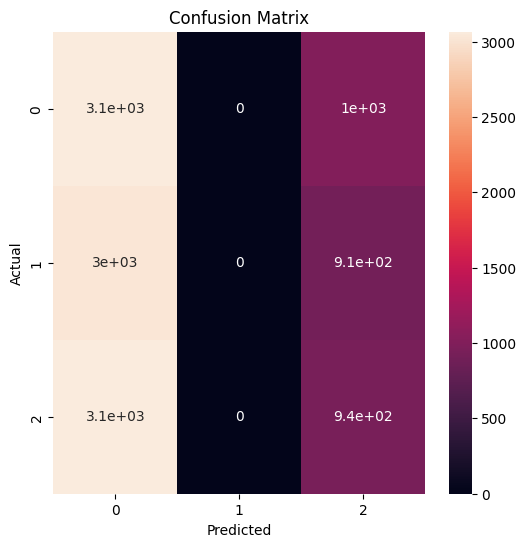

In [ ]:
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [27]:
model.coef_

array([[ 0.45560306, -0.39453398,  0.34537322, -6.03887318, -0.24888042,
         0.06192966, -0.24329739, -0.16909368, -0.01227406, -0.04926834,
        -0.13209939, -0.05478682, -0.12658091,  0.00991821, -0.16198312,
        -0.02930283, -0.37641873,  0.19505099,  0.06220935, -0.12207361,
        -0.12150347, -0.26436014,  0.08299241, -0.16003605,  0.07537626,
        -0.09670794, -0.07531171, -0.0729989 , -0.03305712, -0.27848445,
         0.09711672],
       [-0.42620104, -0.42140271, -0.4368181 , -1.26823848, -0.22424601,
        -0.10217406,  0.00906216,  0.15659563, -0.24970753, -0.01593774,
        -0.07717415,  0.15330361, -0.24641551, -0.03725691, -0.0805755 ,
         0.02472051,  0.07574073, -0.16885263, -0.1011658 ,  0.0738214 ,
        -0.06576749,  0.17859506, -0.27170696,  0.12294658, -0.10563615,
        -0.11042233, -0.12393054,  0.15816268, -0.12734404, -0.06754105,
        -0.02557085],
       [-0.22524037, -0.05393872, -0.47142691,  1.21009565, -0.19007742,
       

##### Kneighbors

In [ ]:
clf = KNeighborsClassifier(n_neighbors=3, algorithm="auto")
clf.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=3)

In [75]:
y_predict = clf.predict(X_test)

In [76]:
accuracy_score(y_test, y_predict)

0.3259166666666667

SVC

In [ ]:
# Import necessary libraries
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

# Step 1: Train Naive Bayes Model
nb_model = GaussianNB()
nb_model.fit(X_train, y_train)

# Step 2: Make Predictions with Naive Bayes
y_pred_nb = nb_model.predict(X_test)

# Step 3: Evaluate Naive Bayes Model
nb_accuracy = accuracy_score(y_test, y_pred_nb)

# Step 4: Train SVM Model
svm_model = SVC(kernel="rbf", C=5.0, random_state=42)
svm_model.fit(X_train, y_train)

# Step 5: Make Predictions with SVM
y_pred_svm = svm_model.predict(X_test)

# Step 6: Evaluate SVM Model
svm_accuracy = accuracy_score(y_test, y_pred_svm)

# Display the results
nb_accuracy, svm_accuracy

(0.3324166666666667, 0.3298333333333333)

In [23]:
decision_functions = svm_model.decision_function(X_train)

In [24]:
len(decision_functions), len(X_train)

(28000, 28000)

In [ ]:
results = permutation_importance(
    svm_model, X_test, y_test, n_repeats=10, random_state=42
)

for i, importance in enumerate(results.importances_mean):
    print(f"Feature {i + 1}: {importance}")

Feature 1: -0.006691666666666668
Feature 2: -0.0044750000000000015
Feature 3: -0.0005499999999999839
Feature 4: 3.333333333332966e-05
Feature 5: 0.0
Feature 6: 0.0
Feature 7: 0.0
Feature 8: 0.0
Feature 9: 0.0
Feature 10: 0.0
Feature 11: 0.0
Feature 12: 0.0
Feature 13: 0.0
Feature 14: 0.0
Feature 15: 0.0
Feature 16: 0.0
Feature 17: 0.0
Feature 18: 0.0
Feature 19: 0.0
Feature 20: 0.0
Feature 21: 0.0
Feature 22: 0.0
Feature 23: 0.0
Feature 24: 0.0
Feature 25: 0.0
Feature 26: 0.0
Feature 27: 0.0
Feature 28: 0.0
Feature 29: 0.0
Feature 30: 0.0
Feature 31: 0.0


In [34]:
X_train.columns

Index(['Source Port', 'Destination Port', 'Packet Length', 'Anomaly Scores',
       'Severity Level', 'Malware Indicators_absent',
       'Malware Indicators_present', 'Firewall Logs_absent',
       'Firewall Logs_present', 'IDS/IPS Alerts_absent',
       'IDS/IPS Alerts_present', 'Alerts/Warnings_absent',
       'Alerts/Warnings_present', 'Protocol_ICMP', 'Protocol_TCP',
       'Protocol_UDP', 'Packet Type_Control', 'Packet Type_Data',
       'Traffic Type_DNS', 'Traffic Type_FTP', 'Traffic Type_HTTP',
       'Attack Signature_Known Pattern A', 'Attack Signature_Known Pattern B',
       'Action Taken_Blocked', 'Action Taken_Ignored', 'Action Taken_Logged',
       'Network Segment_Segment A', 'Network Segment_Segment B',
       'Network Segment_Segment C', 'Log Source_Firewall',
       'Log Source_Server'],
      dtype='object')

In [235]:
cols = [
    "Destination Port",
    "Packet Length",
    "Severity Level",
    "Attack Signature_Known Pattern A",
    "Malware Indicators_absent",
    "Alerts/Warnings_absent",
    "Packet Type_Control",
    "Log Source_Firewall"
]

In [231]:
svm_model_2 = SVC(kernel="rbf", C=5.0, random_state=42)

In [236]:
svm_model_2.fit(X_train[cols], y_train)

SVC(C=5.0, random_state=42)

In [237]:
y_predict = svm_model_2.predict(X_test[cols])

In [238]:
accuracy_score(y_test, y_predict)

0.33116666666666666

malware: 0.335
firewall logs: 0.325
IDS/IPS alerts: 0.332
Alerts/warnings: 0.331
protocols: 0.328
packet types: 0.34
Traffic types: 0.327
Attack signature known: 0.328
Action taken: 0.326
Network segments: 0.329
Log source: 0.333

Source port: 0.321
Destination port: 0.333
Packet length: 0.331
anomaly score: 0.323
Severity level: 0.329

['Destination port', 'Packet Length','Severity Level', 'Attack Signature_Known Pattern A', 'Malware Indicators_absent', 'Alert/Warnings_absent'] :  0.331


Shap values with XGBoost tree classifier 

In [154]:
y_train_transformed = y_train.copy()
y_test_transformed = y_test.copy()


y_train_transformed.loc[y_train_transformed == "Malware"] = 0
y_train_transformed.loc[y_train_transformed == "DDoS"] = 1
y_train_transformed.loc[y_train_transformed == "Intrusion"] = 2
y_test_transformed.loc[y_test_transformed == "Malware"] = 0
y_test_transformed.loc[y_test_transformed == "DDoS"] = 1
y_test_transformed.loc[y_test_transformed == "Intrusion"] = 2

In [156]:
y_test_transformed

7072     1
30876    2
8547     2
16807    2
13174    1
        ..
20995    0
20506    2
39441    2
9991     1
19132    2
Name: Attack Type, Length: 12000, dtype: object

In [153]:
param = {
    "max_depth": 2,
    "eta": 1,
    "objective": "multi:softmax",
    "nthread": 3,
    "eval_metric": "auc",
    "max_depth": 4,
    "min_child_weight": 2,
}

model = xgb.XGBClassifier(param)

model.fit(X_train, y_train_transformed)

c:\Users\laura\Documents\DSTI\Courses\Machine learning python labs\Project 1\.venv\Lib\site-packages\xgboost\core.py:723: FutureWarning: Pass `objective` as keyword args.
  warnings.warn(msg, FutureWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [ ]:
y_predict = model.predict(X_test)

In [172]:
type(y_predict[0]), type(y_test_transformed[0])

y_predict = pd.Series(y_predict)

In [173]:
root_mean_squared_error(y_test_transformed, y_predict)

1.1567194992737004

c:\Users\laura\Documents\DSTI\Courses\Machine learning python labs\Project 1\.venv\Lib\site-packages\numpy\lib\_histograms_impl.py:835: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
c:\Users\laura\Documents\DSTI\Courses\Machine learning python labs\Project 1\.venv\Lib\site-packages\numpy\lib\_histograms_impl.py:836: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


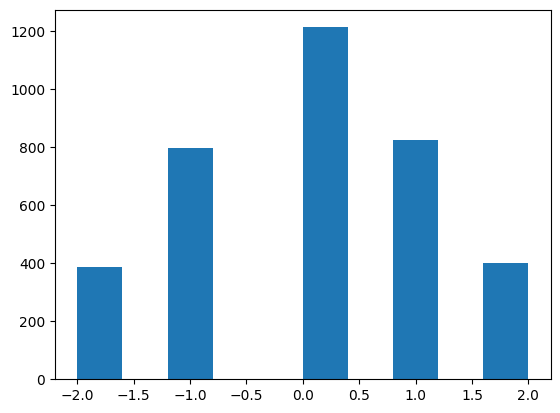

In [180]:
residuals = y_test_transformed - y_predict
plt.hist(residuals)
plt.show()

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

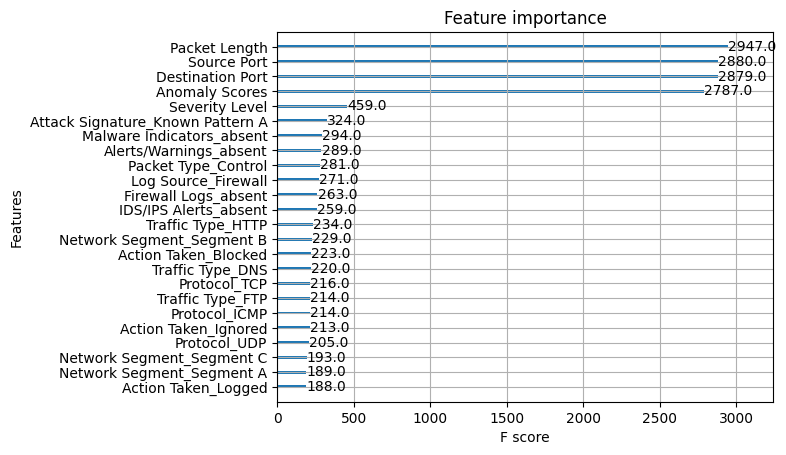

In [181]:
xgb.plot_importance(model)

In [201]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train)

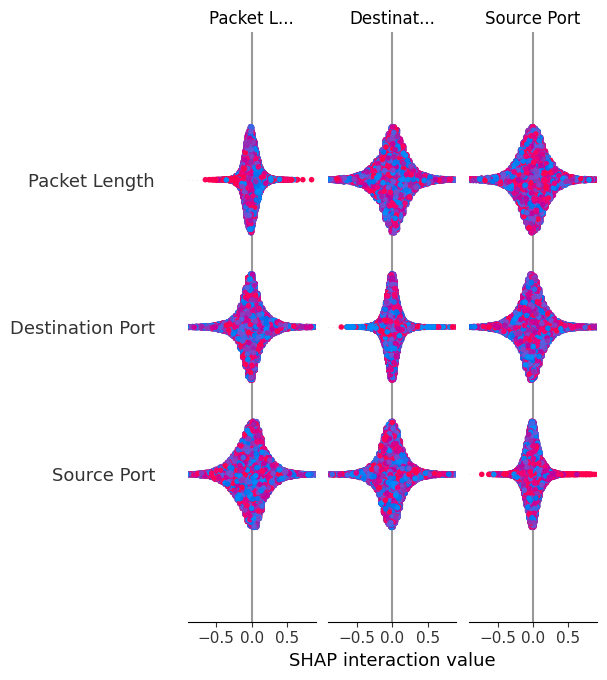

In [202]:
shap.summary_plot(shap_values, X_train)